# 구글 이미지로 나만의 데이터셋 만들기
*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

이 튜토리얼을 통해 어떤 카테고리의 이미지라도 구글 이미지를 통해 데이터셋을 구하는 방법을 터득해보자.

이 노트북에서는 teddy bear, black bear, grizzly bear를 분류하기 위해 세 가지 데이터 셋을 모으고, 이를 분류하는 모델을 만들어본다.

In [0]:
from fastai.vision import *

## Get a list of URLs

### Search and scroll

[Google Images](http://images.google.com) 에 접속해서 찾고자하는 이미지를 검색하자. 가능한 자세한 검색어를 입력해야 좋은 데이터를 얻을 수 있다. 

(너무 제너럴하면 원하는 이미지 이외의 것들이 포함될듯)

계속 스크롤을 내리다보면, 'Show more results' 버튼이 나온다.

이 버튼 이전에 나온 이미지들은 모두 [다운로드 가능]한 상태이다. 

계속해서 이미지늘 더 불러오면, 최대 700개의 이미지를 다운로드 가능한 상태로 만들 수 있다.

아래와 같이 제외할 키워드를 넣어서 검색하는 것은 더 양질의 데이터를 얻는데 도움이 된다.

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis



### Download into file

구글 이미지에서 이미지를 필요한 만큼 로드했다면, 아래 단축키로 콘솔을 열고, 자바스크립트 코드를 실행시키자.

<kbd>Ctrl</kbd> <kbd>Shift</kbd> <kbd>J</kbd> in Windows/Linux 

 <kbd>Cmd</kbd> <kbd>Opt</kbd> <kbd>J</kbd> in Mac



```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

그러면 구글 이미지에 로드된 모든 이미지의 다운로드 URL을 하나의 텍스트 파일로 저장할 수 있다.

### 드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_dir = '/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/'

### Create directory and upload urls file into your server

아래 코드를 실행시켜 설정한 base_dir/data/bears 에 teddys, grizzly, black 세 폴더를 만들자.

(튜토리얼 원본 코드를 수정함)

In [0]:
classes = ['teddys','grizzly','black']
path = Path(base_dir+'data/bears')

## 디렉터리 생성  이미 다운 받았다면 스킵할 것

In [0]:
for bear in classes:
  folder = bear
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

path.ls()

[PosixPath('/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears/urls_grizzly.csv'),
 PosixPath('/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears/urls_teddys.csv'),
 PosixPath('/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears/urls_black.csv'),
 PosixPath('/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears/teddys'),
 PosixPath('/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears/grizzly'),
 PosixPath('/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears/black')]

***생성된 data/bears 디렉터리에 아까 저장해둔 이미지 URL 파일을 ```urls_black.csv ``` 형태로 저장해 업로드(이동) 하자.***

## Download images 이미 다운 받았다면 스킵할 것

이제 저장된 URL을 가지고 이미지를 다운받자. 

fast.ai에는 download_images 함수를 사용하면 url로부터 이미지를 다운받을 수 있다.
url이 저장된 csv 파일 경로를 인자로 주고, 이미지를 저장할 위치도 인자로 주자.


In [0]:
for bear in classes:
  folder = bear
  file = 'urls_' + bear + '.csv'
  dest = path/folder
  download_images(path/file, dest, max_pics=300)

In [0]:
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

다운 받은 이미지중 열 수 없는 이미지 혹은 rgb 채널이 아닌 이미지 등등... 을 삭제하자.


In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500) # delete = True 로 잘못된 이미지 바로삭제

## View data

이제 저장한 데이터를 DataBunch로 만들자. 이전 노트에서 언급한것과 같이 데이터번치 자료구조를 사용하면 자동으로 validation set 이 생성된다. (여기선 20%)

from_folder 로 DataBunch 를 생성하면 폴더명이 클래스로 레이블링 된다.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats) # 이미지를 정규화도 해주자(normalize)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

데이터 번치가 잘 만들어 졌는지 확인해보자.

In [7]:
data.classes

['black', 'grizzly', 'teddys']

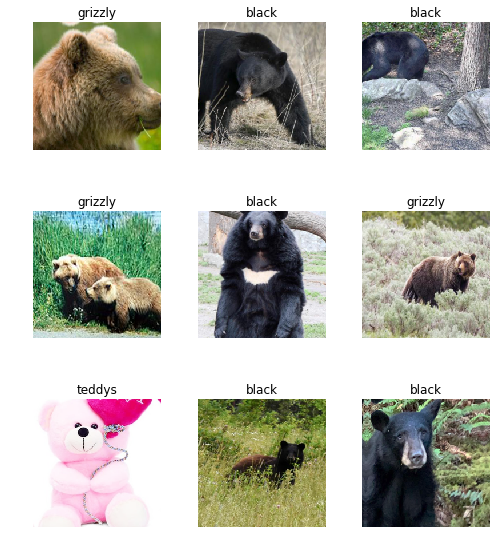

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 655, 163)

In [10]:
data

ImageDataBunch;

Train: LabelList (655 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
teddys,teddys,teddys,teddys,teddys
Path: /content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears;

Valid: LabelList (163 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
teddys,grizzly,black,grizzly,black
Path: /content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears;

Test: None

## Train model

resnet34 모델을 불러와 전이학습을 진행하자.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.799316,0.176577,0.061350,00:12
1,0.447642,0.171418,0.024540,00:11
2,0.332075,0.149207,0.030675,00:11
3,0.252103,0.145519,0.030675,00:11


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


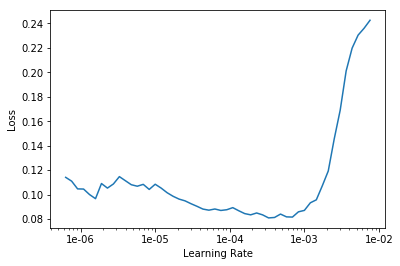

In [16]:
learn.recorder.plot()

In [0]:
# If the plot is not showing try to give a start and end learning rate# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.110115,0.206502,0.042945,00:11
1,0.095085,0.205058,0.042945,00:11


freeze 상태보다 unfreeze + 더 좋은 learning rate를 적용하니 성능향상이 있었다.

In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

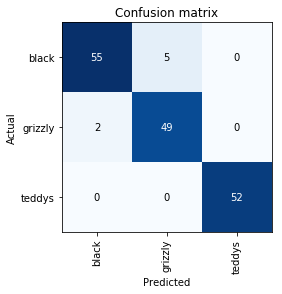

In [21]:
interp.plot_confusion_matrix()

confusion matrix 를 그려보니 black bear를 grizzly 로 5번 잘못 예측하였다. (검은곰과 회색곰은 사람이 봐도 어려울 것 같긴 하다.)

# 이 아래는 colab 에서 실행 불가능 하다. 

## Cleaning Up

가장 많이 틀린 데이터가 어떤 이미지였는지 살펴보자.

왜냐하면 구글 이미지에서 잘못된 이미지를 데이터셋으로 포함 시켰을 수도 있기 때문이다. 

`fastai.widgets` 의 `ImageCleaner` 윗젯을 사용하면 가장 loss가 높았던 이미지를 불러와 GUI 환경에서 삭제할 수 있다.

In [0]:
from fastai.widgets import *

일단 `.from_toplosses` 를 사용해서 가장 loss가 컸던 파일들의 path 를 알 수 있다.

 이후 `ImageCleaner` 에 해당 이미지들의 path 를 전달해 주자.

주의할 점은 이 위젯이 이미지를 disk 에서 삭제하는 것이 아니고, 해당 이미지가 포함되지 않은 새로운 csv 파일인 `cleaned.csv` 을 만든다는 것이다. 이 새로 생성된 파일을 가지고 다시 ImageDataBunch 를 생성하자.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .no_split()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

In [23]:
db # 새로 만든 ImageDataBunch 이다.

ImageDataBunch;

Train: LabelList (818 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
teddys,teddys,teddys,teddys,teddys
Path: /content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears;

Test: None

이제 새로운 learner 를 만들어 새로운 databunch (db) 로 학습 시키자.

In [1]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

NameError: ignored

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

## 이 아래는 colab 에서 실행 불가능 하다. 

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [0]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
# ImageCleaner(ds, idxs, path)

'No images to show :)'


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [28]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

# 여기서부터 다시 진행

## Putting your model in production

처음으로 할 일은  `Learner` 객체의 모든것을 저장(export)하는 것이다.

doc 에는 이렇게 적혀있다.

```
Once everything is ready for inference, we just have to call learn.export to save all the information of our Learner object for inference: the stuff we need in the DataBunch (transforms, classes, normalization...), the model with its weights and all the callbacks our Learner was using. Everything will be in a file named export.pkl in the folder learn.path. If you deploy your model on a different machine, this is the file you'll need to copy.

```

In [23]:
learn.path

PosixPath('/content/drive/My Drive/develop/course-v3-master/course-v3-master/nbs/dl1/data/bears')

In [0]:
learn.export() # 학습한 모델의 모든 정보를 learn.path 폴더에 export.plk 파일로 저장한다.

'export.pkl' 파일이 learn.path 경로에 저장될 것이다. 모델이 다시 구현되기에 필요한 모든 정보들( weights, class 정보, transforms, 사용한 normalization...)

여태 GPU를 사용해서 모델을 학습하였으나, 모델을 실제 프로덕트로 사용하기에는 GPU 보다 CPU가 적합하다. (GPU로 데이터를 옮기는 오버해드, inference에는 많은 연산이 필요X)

In [0]:
defaults.device = torch.device('cpu') # 파이토치랑 똑같다!

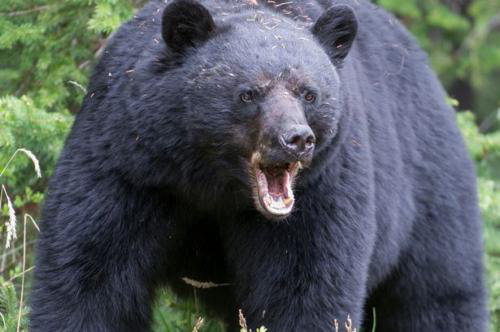

In [25]:
img = open_image(path/'black'/'00000021.jpg')
img

`Learner` 에 대한 정보를 export.pkl 에 저장해 두었으니, 모델을 재사용 할때 load_learner 함수를 통해 불러오면 된다.

In [0]:
learn = load_learner(path)

In [28]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category black

위 사진을 black으로 잘 예측한것을 확인할 수 있다.

파이썬으로 서버를 만들어 모델을 사용한다면 다음과 같이 코드를 꾸릴 수 있겠다.

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- 대부분의 경우 default 세팅으로도 잘 학습된다.
- 실제로 직접 튜닝해야하는 부분은 거의 없다.
- 그래도 아래 두가지 정도는 잘 튜닝해서 사용해 보자.
  - Learning rate
  - Number of epochs

### Learning rate 가 너무 크면

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [30]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,12.353809,48278420.000000,0.680982,00:10


학습이 전혀 이뤄지지 않는다.

### Learning rate 가 너무 작으면

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

이전 결과를 가져와 보면..:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [32]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.508507,1.136937,0.644172,00:11
1,1.472829,1.083577,0.570552,00:11
2,1.437368,1.043774,0.515337,00:11
3,1.411931,1.025718,0.490798,00:11
4,1.402951,1.024337,0.490798,00:11


학습은 이뤄지나, 한 에폭마다 너무 조금씩 수렴한다.

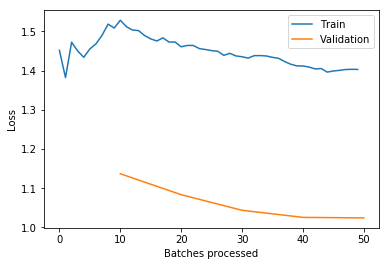

In [34]:
learn.recorder.plot_losses()

### Too few epochs

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [36]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.887020,0.773470,0.337423,00:12


### Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [38]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 99228476.15it/s]


In [39]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.201785,1.222438,0.682065,00:11
1,1.186650,1.156090,0.663043,00:09
2,1.158077,1.088160,0.611413,00:09
3,1.104976,1.000327,0.524457,00:09
4,1.050502,0.887918,0.361413,00:09
5,0.972149,0.763175,0.269022,00:09
6,0.895703,0.626200,0.173913,00:09
7,0.814165,0.508928,0.126359,00:09
8,0.733496,0.413990,0.100543,00:09
9,0.663287,0.340194,0.084239,00:09


Train loss 가 Val loss 보다 작아진다면 그 지점부터 오버피팅을 의심해 봐야 할 것이다.